# Data Science Task <a class='tocSkip'>

The *spam_data__training_set.csv* contains ads data from the Real Estate category with a label indicating if it’s spam.

**Your task is to build and train a model that allows to identify spam content based on the provided ad parameter.**

The output of your work should be a script that we can run in Jupyter notebooks and which would allow us to run your model on our validation set. 


## Libraries import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import morfeusz2
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc

## Loading data

### For the automatic validation please put the file named ``spam_data__validation_set.csv`` in the ``data`` folder.

In [2]:
# Training Set
training_set = 'data/spam_data__training_set.csv'
df_train = pd.read_csv(training_set, sep=None, engine='python', encoding='utf-8')
print('Training set ready.')

# Validation Set
try:
    validation_set = 'data/spam_data__validation_set.csv'
    df_val = pd.read_csv(validation_set, sep=None, engine='python', encoding='utf-8')
    print('Validation set ready.')
except FileNotFoundError:
    print('Validation set not found. Check the name and path of the file.')

Training set ready.
Validation set not found. Check the name and path of the file.


In [3]:
df_train.head()

,ID,TITLE,DESCRIPTION,PRICE,SPAM_FLAG,Unnamed: 5
0,43925,Pracownia plastyczna 'artystart'/Fundacja Serd...,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",50,1,NaN
1,67238,Owczarki Niemieckie Długowłose-OGROMNE- Owczar...,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",3500,1,NaN
2,93863,Tusz (Kardridż) HP 41,Oryginalny kardridż firmy HP 41. Zapakowany w ...,5,1,NaN
3,126634,Zespół muzyczny ODLOT,. Zapewniamy profesjonalną oprawę muzyczną na ...,2500,1,NaN
4,169161,Super kultowa książka Moja dziewczyna,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",5,1,NaN


In [4]:
# Dropping two useless columns
df_train.drop(['ID', 'Unnamed: 5'], axis=1, inplace=True)

In [5]:
df_train.head()

,TITLE,DESCRIPTION,PRICE,SPAM_FLAG
0,Pracownia plastyczna 'artystart'/Fundacja Serd...,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",50,1
1,Owczarki Niemieckie Długowłose-OGROMNE- Owczar...,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",3500,1
2,Tusz (Kardridż) HP 41,Oryginalny kardridż firmy HP 41. Zapakowany w ...,5,1
3,Zespół muzyczny ODLOT,. Zapewniamy profesjonalną oprawę muzyczną na ...,2500,1
4,Super kultowa książka Moja dziewczyna,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",5,1


In [6]:
# Checking distribution of classes to assess the baseline for classifier
print('Mean value:', df_train['SPAM_FLAG'].mean())
print('Distribution:')
print(df_train['SPAM_FLAG'].value_counts())

Mean value: 0.4973295633050581
Distribution:
0    4800
1    4749
Name: SPAM_FLAG, dtype: int64


Classes are balanced

## Lemmatization using Morfeusz library

In [7]:
# Using SGJP dictionary
morf = morfeusz2.Morfeusz(dict_path='./data', dict_name='sgjp')
morf.dict_id()

'pl.sgjp.sgjp-2018.10.14'

**Helper function for automatic lemmatization**

In [8]:
def lemmatizer(df, col):
    '''
    Arguments:
    df: DataFrame with columns to be lemmatized,
    col: Column name to be lemmatized, eg. 'DESCRIPTION'
    '''
    
    
    # Generating list from column values
    raw_ = [str([art]) for art in df[col]]

    # Small letters 
    lower_ = [art.lower() for art in raw_]

    # Tokenization
    tokenized_ = [nltk.word_tokenize(art) for art in lower_]

    # Removing punctuation chars
    no_punc_ = [[token for token in art if token not in string.punctuation] for art in tokenized_]

    # Removing stopwords
    stopwords = './data/polishstopwords.txt'
    no_stopw_ = [[token for token in art if not token in stopwords] for art in no_punc_]

    # Lemmatization
    morf = morfeusz2.Morfeusz(expand_tags=False, dict_path='./data/', dict_name='sgjp')
    lemmatized__ = [[morf.analyse(token)[0][2][1] for token in art] for art in no_stopw_]

    # Removing artifacts after lemmatization
    lemmatized_ = [[token.split(':')[0] for token in art] for art in lemmatized__]

    # Joining tokens back together into corpus
    cleaned_ = [' '.join(tokens) for tokens in lemmatized_]

    # Returning new dataframe with lemmatized values
    return pd.DataFrame(cleaned_)

In [9]:
desc = lemmatizer(df_train, 'DESCRIPTION')

In [10]:
title = lemmatizer(df_train, 'TITLE')

In [11]:
# Concatenation of lemmatized columns
df_adult = pd.concat([title, desc, df_train['PRICE'], df_train['SPAM_FLAG']], axis=1)
df_adult.columns = ['TITLE','DESCRIPTION','PRICE','SPAM_FLAG']

## Classification
Using TF-IDF vectorizer and Multinomial Naive Bayes as a predictor

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       929
           1       1.00      0.98      0.99       981

   micro avg       0.99      0.99      0.99      1910
   macro avg       0.99      0.99      0.99      1910
weighted avg       0.99      0.99      0.99      1910



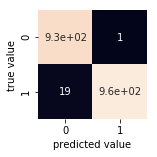

In [12]:
# Spliting data into train and test sets
train_df, test_df = train_test_split(df_adult, test_size=0.2, shuffle=True, random_state=42)

# Defining pipeline steps and fitting classifier
steps = [('tfidf', TfidfVectorizer()), ('cls', MultinomialNB())]
pipe = Pipeline(steps=steps)
pipe.fit(train_df['DESCRIPTION'], train_df['SPAM_FLAG'])

y_pred = pipe.predict(test_df['DESCRIPTION'])
y_true = test_df['SPAM_FLAG']

# Returning results
plt.figure(figsize=(2,2))
sns.heatmap(confusion_matrix(y_true, y_pred), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

print(classification_report(y_true, y_pred))

### ROC curve

AUC: 1.000


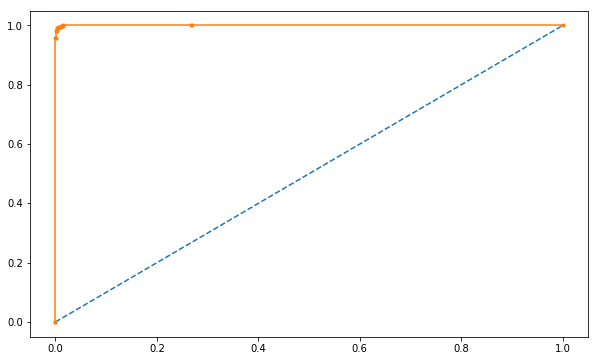

In [13]:
# Probabilities (only positive)
probas = pipe.predict_proba(test_df['DESCRIPTION'])
probas = probas[:, 1]
# AUC
auc = roc_auc_score(y_true, probas)
print('AUC: {:.3f}'.format(auc))
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, probas)
plt.figure(figsize=(10,6))
# No-skill line
plt.plot([0, 1], [0, 1], linestyle='--')
# Model
plt.plot(fpr, tpr, marker='.')
plt.show()

## Validation

In [14]:
try:
    description_val = lemmatizer(df_val, 'DESCRIPTION')
    title_val = lemmatizer(df_val, 'TITLE')
    
    df_adult_val = pd.concat([title_val, description_val, df_val['PRICE'], df_val['SPAM_FLAG']], axis=1)
    df_adult_val.columns = ['TITLE','DESCRIPTION','PRICE','SPAM_FLAG']
    
    y_pred = pipe.predict(df_adult_val['DESCRIPTION'])
    y_true = df_adult_val['SPAM_FLAG']

    plt.figure(figsize=(2,2))
    sns.heatmap(confusion_matrix(y_true, y_pred), square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('true value');
    print(classification_report(y_true, y_pred))
    
except NameError:
    print('No such dataframe. Check name and proper path to file.')

No such dataframe. Check name and proper path to file.


### ROC curve

In [15]:
try:
    # Probabilities (only positive)
    probas = pipe.predict_proba(df_adult_val['DESCRIPTION'])
    probas = probas[:, 1]
    # AUC
    auc = roc_auc_score(y_true, probas)
    print('AUC: {:.3f}'.format(auc))
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, probas)
    plt.figure(figsize=(10,6))
    # No-skill line
    plt.plot([0, 1], [0, 1], linestyle='--')
    # Model
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    
except NameError:
    print('No such dataframe. Check name and proper path to file.')

No such dataframe. Check name and proper path to file.


## LSTMs with word2vec embeddings (keras)

**See second notebook:** <br>
[Spam classification with LSTMs](Data%20Science%20Task%20-%20polish%20language%20spam%20detection%20-%20word2vec%20embeddings%20with%20LSTMs.ipynb)